In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [3]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


# Importing DL Libraries

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [5]:
if(torch.cuda.is_available()):
    device = torch.device('cuda:0')
    print('Running on the GPU')
else:
    device = torch.device('cpu')
    print('Running on the CPU')

Running on the GPU


# Downloading and processing the data

In [6]:
import torchvision 
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [8]:
dataset = MNIST(root = 'data/',
               download = True,
               transform = ToTensor())

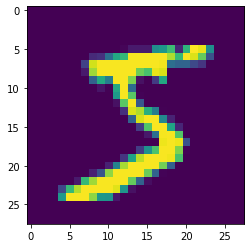

In [9]:
plt.imshow(dataset[0][0].view(28,28))

# Splitting the data into batches

In [10]:
def split_indices(n, val_indices):
    val = int(n * val_indices)
    perm = np.random.permutation(n)
    return perm[val:], perm[:val]

In [11]:
train_ind, val_ind = split_indices(len(dataset), 0.2)
print(len(train_ind), len(val_ind))

48000 12000


In [12]:
batch_size = 128

# Training Set
train_sample = SubsetRandomSampler(train_ind)
train_dl = DataLoader(dataset,
                      batch_size,
                      sampler = train_sample)

# Validation Set
val_sample = SubsetRandomSampler(val_ind)
val_dl = DataLoader(dataset,
                    batch_size,
                    sampler = val_sample)

# Creating the NN model

In [9]:
class Flatten(nn.Module):
    
    def __init__(self):
        super().__init__()
        
    def __call__(self, x):
        y = torch.flatten(x)
        return y.view(len(x), -1)

    
model = nn.Sequential(nn.Conv2d(1,32,3),
                      nn.MaxPool2d(2,2),
                      nn.Conv2d(32,64,3),
                      nn.MaxPool2d(2,2),
                      nn.Conv2d(64,128,3),
                      nn.MaxPool2d(2,2),
                      Flatten(),
                      nn.Linear(128,64),
                      nn.ReLU(),
                      nn.Linear(64,10))

In [16]:
model.to(device)
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr = 1e-4)

# Training and Testing the Model

In [17]:
def train(model, criterion, optimiser, epochs = 6):
    f = open('loss.txt', 'w')
    
    for _ in range(epochs):
        for X_batch, y_batch in tqdm(train_dl):

            X_batch = X_batch.view(-1,1,28,28).to(device)
            y_batch = y_batch.to(device)
            
            model.zero_grad()
            pred = model(X_batch)
            loss = criterion(pred, y_batch.long())

            loss.backward()
            optimiser.step()
            f.write(str(float(loss)) + '\n')

            del X_batch, y_batch
            torch.cuda.empty_cache()
    
    f.close()
    record = []
    f = open('loss.txt', 'r')

    for line in f:
        record.append(float(line))
        
    plt.plot(record)
    plt.show()

In [18]:
def val(model, criterion):
    
    with torch.no_grad():
        f = open('acc.txt', 'w')
        
        for X_batch, y_batch in val_dl:
            
            X_batch = X_batch.view(-1,1,28,28).to(device)
            y_batch = y_batch.to(device)
            
            pred = model(X_batch)
            loss = criterion(pred, y_batch.long())
            correct = 0
            
            for i in range(len(y_batch)):
                correct += 1 if torch.argmax(pred[i]) == y_batch[i] else 0
            
            f.write(str(correct / len(y_batch)) + '\n')
        
        f.close()
        record = []
        f = open('acc.txt', 'r')

        for line in f:
            record.append(float(line))

        plt.plot(record)
        plt.show()   

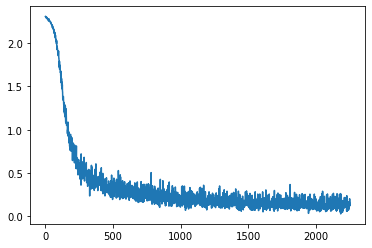

In [20]:
train(model, criterion, optimiser)

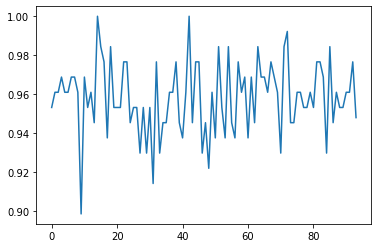

In [21]:
val(model, criterion)

# Saving the Model

In [23]:
torch.save(model.state_dict(), 'CNN.pth')

# Loading the Saved Model

In [10]:
model.load_state_dict(torch.load('CNN.pth'))

<All keys matched successfully>

In [16]:
model.to(device)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
  (7): Linear(in_features=128, out_features=64, bias=True)
  (8): ReLU()
  (9): Linear(in_features=64, out_features=10, bias=True)
)

# Trying a self generated image

In [33]:
img = plt.imread("3.png")
img.shape

(28, 28, 3)

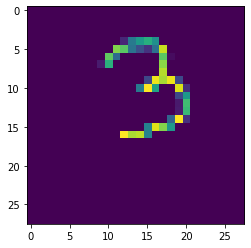

In [34]:
img = img[:,:,0]
plt.imshow(img)

In [35]:
data = torch.Tensor(img).view(-1,1,28,28).to(device)
pred = model(data)

In [36]:
torch.argmax(pred)

tensor(3, device='cuda:0')